This notebook adds some time & seasonality features to the consumption data, to be used as covariates in the sequence models in notebooks 3.1 and 3.2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import periodogram

In [2]:
output_dir = "./OutputData/"

In [3]:
# Load full data, convert time to datetime
df = pd.read_csv(output_dir + "full_data.csv")
df["time"] = pd.to_datetime(df["time"], format = "%d:%m:%Y:%H:%M")

In [4]:
# Drop generation columns
gen_cols = df.columns.values[2:].tolist()
df = df.drop(gen_cols, axis = 1)

In [5]:
# Real-time consumption is available with a 2 hour lag. Shift them back
df["consumption_lag2"] = df["consumption_MWh"].shift(2)
df = df.dropna()

## Annual periodogram

In [6]:
# Calculate strengths of annual frequencies in consumption time series
p = 365 * 24 # Yearly sampling frequency
freqs, spectrum = periodogram(
    x = df.consumption_MWh.values, 
    fs = p, 
    detrend = "linear",
    scaling = "spectrum"
)

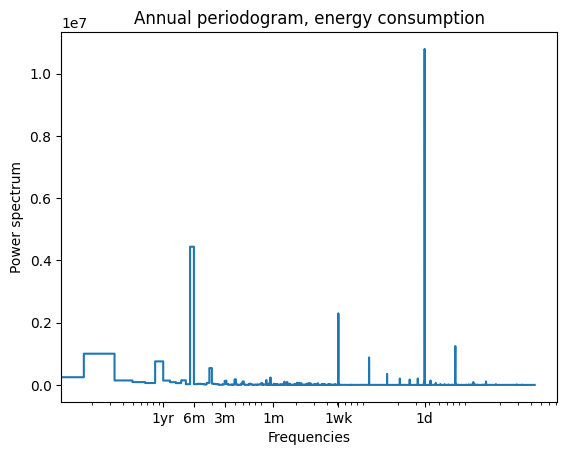

In [7]:
# Plot annual periodogram
fig, ax = plt.subplots()
_ = ax.step(freqs, spectrum)
_ = ax.set_xscale("log")
_ = ax.set_xticks([1, 2, 4, 12, 52, 365])
_ = ax.set_xticklabels(["1yr", "6m", "3m", "1m", "1wk", "1d"])
_ = ax.set_title("Annual periodogram, energy consumption")
_ = ax.set_xlabel("Frequencies")
_ = ax.set_ylabel("Power spectrum")

X-axis corresponds to frequencies: Number of repeats in a year, starting from 1. Y-axis corresponds to the power spectral density of each frequency. 
- A frequency of 1 corresponds to a frequency repeating once per year.
- A frequency of 365 corresponds to a frequency repeating once per day.
- The strongest frequencies are around 2 (biannual seasonality), 52 (day of week seasonality) and 365 (hour of day seasonality).

In [8]:
# Find the exact strongest frequencies
idx_topfreqs = np.argpartition(spectrum, -6)[-6:]
freqs[idx_topfreqs].astype(int)

array([104,   0, 730,  52, 365,   1])

Probably ideal to capture the biannual frequency with 2 Fourier pairs, and leave the day of week & hour of day seasonality to cyclical encoding.
- The remaining two strong frequencies (104, 730) are likely covered by day of week & day of hour seasonality.

## Cyclical encoding

In [9]:
# Add time columns

# Trend
df["trend"] = df.index.values

# Hour of day
hourofday = df.time.dt.hour + 1
df["hour_sin"] = np.sin(2 * np.pi * hourofday / 24)
df["hour_cos"] = np.cos(2 * np.pi * hourofday / 24)

# Day of week
dayofweek = df.time.dt.dayofweek + 1
df["day_sin"] = np.sin(2 * np.pi * dayofweek / 7)
df["day_cos"] = np.cos(2 * np.pi * dayofweek / 7)

# 2 Fourier pairs for biannual seasonality

df["biyear_sin1"] = np.sin(2 * np.pi * df["trend"] / p)
df["biyear_cos1"] = np.cos(2 * np.pi * df["trend"] / p)
df["biyear_sin2"] = np.sin(2 * np.pi * df["trend"] / p * 2) 
df["biyear_cos2"] = np.cos(2 * np.pi * df["trend"] / p * 2) 

# # Month
# month = df.time.dt.month
# df["month_sin"] = np.sin(2 * np.pi * month / 12)
# df["month_cos"] = np.cos(2 * np.pi * month / 12)

In [10]:
df

,time,consumption_MWh,consumption_lag2,trend,hour_sin,hour_cos,day_sin,day_cos,biyear_sin1,biyear_cos1,biyear_sin2,biyear_cos2
2,2018-01-01 02:00:00,24635.32,27412.81,2,7.071068e-01,7.071068e-01,7.818315e-01,0.62349,0.001435,0.999999,0.002869,0.999996
3,2018-01-01 03:00:00,23872.12,26324.39,3,8.660254e-01,5.000000e-01,7.818315e-01,0.62349,0.002152,0.999998,0.004304,0.999991
4,2018-01-01 04:00:00,23194.89,24635.32,4,9.659258e-01,2.588190e-01,7.818315e-01,0.62349,0.002869,0.999996,0.005738,0.999984
5,2018-01-01 05:00:00,23071.96,23872.12,5,1.000000e+00,6.123234e-17,7.818315e-01,0.62349,0.003586,0.999994,0.007173,0.999974
6,2018-01-01 06:00:00,23267.90,23194.89,6,9.659258e-01,-2.588190e-01,7.818315e-01,0.62349,0.004304,0.999991,0.008607,0.999963
...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2023-12-31 19:00:00,35090.93,34549.42,52579,-8.660254e-01,5.000000e-01,-2.449294e-16,1.00000,0.013627,0.999907,0.027252,0.999629
52580,2023-12-31 20:00:00,33310.94,36193.59,52580,-7.071068e-01,7.071068e-01,-2.449294e-16,1.00000,0.014345,0.999897,0.028686,0.999588
52581,2023-12-31 21:00:00,32083.96,35090.93,52581,-5.000000e-01,8.660254e-01,-2.449294e-16,1.00000,0.015062,0.999887,0.030120,0.999546
52582,2023-12-31 22:00:00,30469.49,33310.94,52582,-2.588190e-01,9.659258e-01,-2.449294e-16,1.00000,0.015779,0.999876,0.031554,0.999502


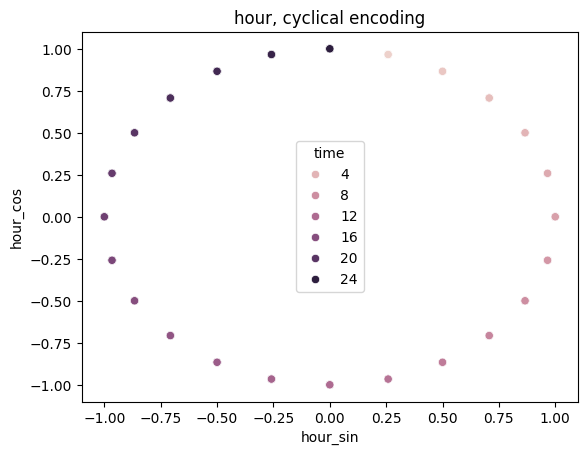

In [11]:
_ = sns.scatterplot(x = df.hour_sin, y = df.hour_cos, hue = hourofday)
_ = plt.title("hour, cyclical encoding")

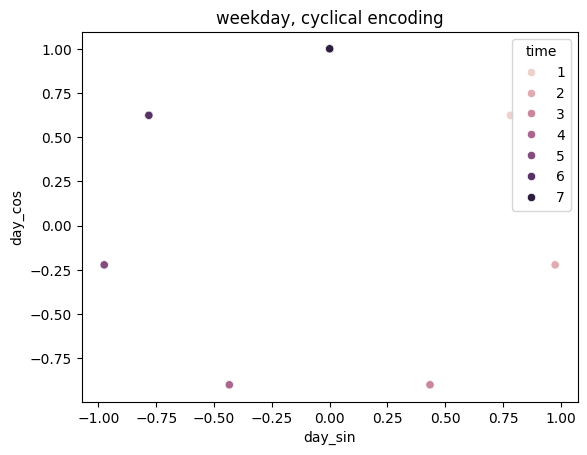

In [12]:
_ = sns.scatterplot(x = df.day_sin, y = df.day_cos, hue = dayofweek)
_ = plt.title("weekday, cyclical encoding")

In [13]:
# _ = sns.scatterplot(x = df.month_sin, y = df.month_cos, hue = month)
# _ = plt.title("month, cyclical encoding")

In [14]:
# Export training data
df.to_csv(output_dir + "train_data.csv", index = False)